# Importing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Unzip image file data**

In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/COSC2673 - Machine Learning Assignment 2/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

#### **Reading 'mainData' CSV file**

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Exploratory Data Analysis

Trends in the .csv file are explored and visualised to determine effective approaches for the model as well as what general predictions the model may make.



#### **Data Balance and Imbalance**

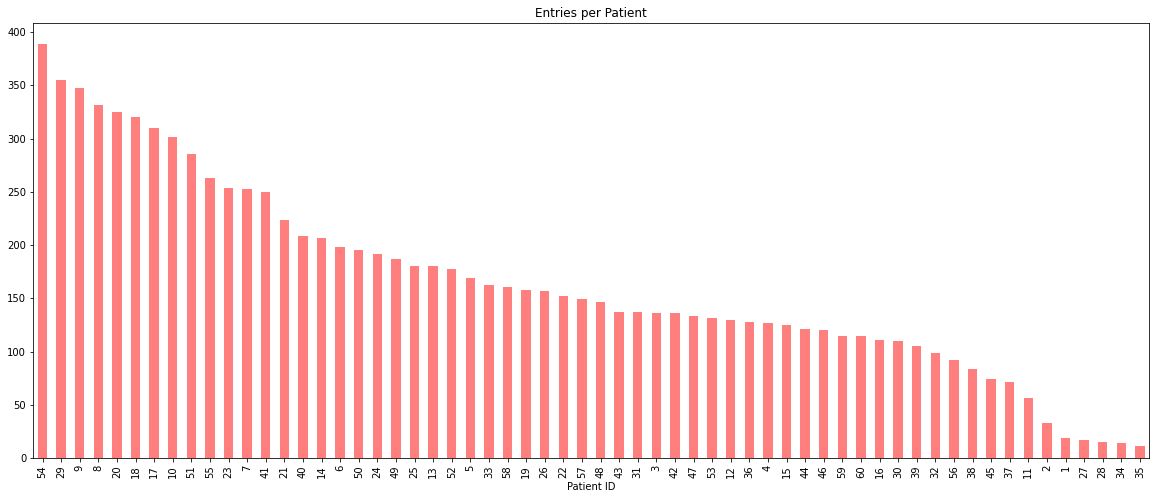

In [ ]:
# Plot the number of entries within the data set per patient
plt.figure(figsize=(20,8))
data['patientID'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)
plt.title("Entries per Patient")
plt.xticks(rotation='vertical')
plt.xlabel("Patient ID")

plt.show()

From the above data, it can be seen that the number of datapoints per patient (a total of 60 patients in the main data set) varies greatly between a range of roughly 10 to 400, making it unbalanced.

Another thing to take into account is that although it is normally expected that ID values should not have influence over the training of a machine learning model, datapoints in this case can originate from the same patient, adding bias to the data. This would eventuate data leaks between the test and training data sets if patient ID is not taken into account when splitting. 

In saying this, a possible solution to this would be to perform splits while ensuring that datapoints from the same patient ID are kept grouped together. For example, all datapoints from patients 1, 2, 3, 4, 5 can be set aside for training and datapoints from patients 6, 7, 8, 9, 10 can be set aside for testing (given that the number of datapoints within the split data sets are proportioned)

=======================================================

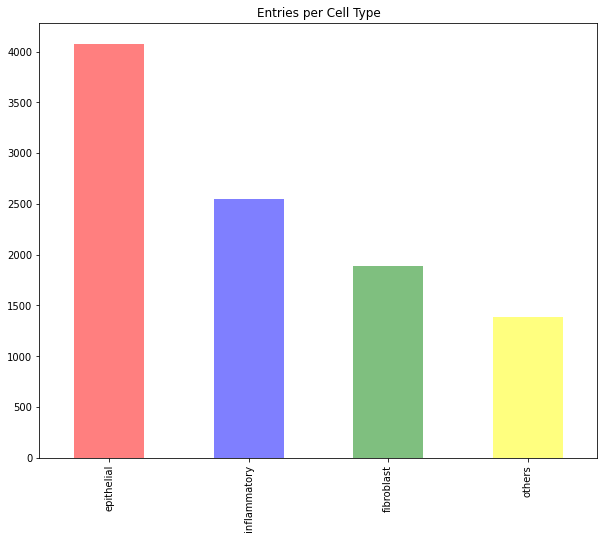

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64


In [ ]:
# Plot the number of entries within the data set per cell type
plt.figure(figsize=(10,8))
data['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red', 'blue', 'green', 'yellow'], alpha=0.5)
plt.title("Entries per Cell Type")
plt.xticks(rotation='vertical')

plt.show()

print(data['cellTypeName'].value_counts())

It can be see that there is an imbalance in the frequencies of the different cell types, however, apart from the 'others' type, there is only little difference.

=======================================================

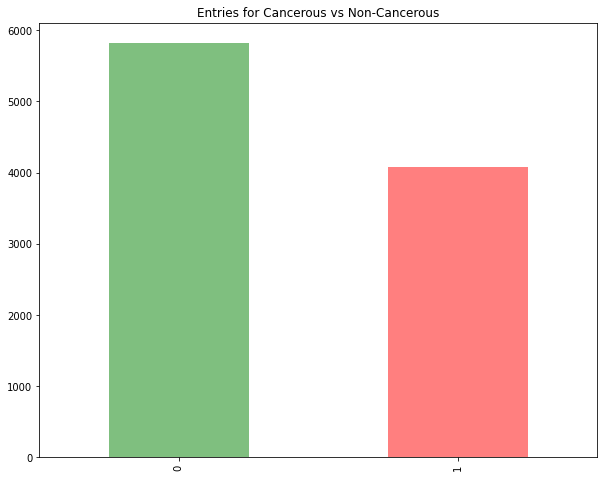

0    5817
1    4079
Name: isCancerous, dtype: int64


In [ ]:
# Plot the number of entries within the data set based on whether the cell is cancerous or not
plt.figure(figsize=(10,8))
data['isCancerous'].value_counts().plot(kind='bar', rot=0, color=['green', 'red'], alpha=0.5)
plt.title("Entries for Cancerous vs Non-Cancerous")
plt.xticks(rotation='vertical')

plt.show()

print(data['isCancerous'].value_counts())

Above, there is an imbalance in the frequencies of datapoints that are labelled cancerous and non-cancerous, however this can be considered a small difference and is expected to cause little influence on the training of the model.

#### **Frequency of Cancerous & Non-Cancerous Cells vs Cell Type**

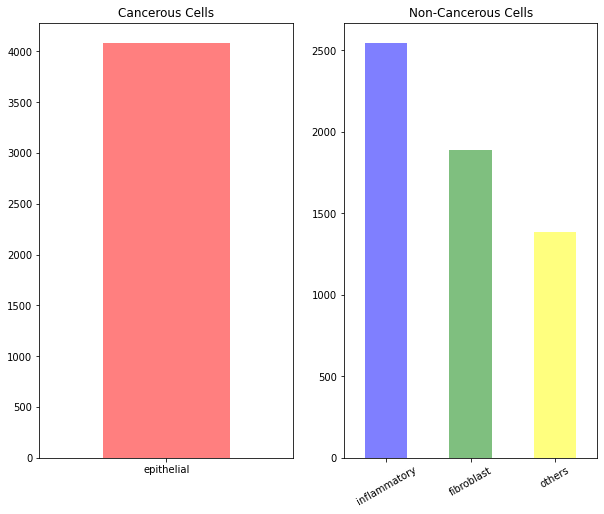

In [ ]:
# Split data into cancerous and non-cancerous sets for plotting
cancerousCellData = data[data['isCancerous'] == 1]
nonCancerousCellData = data[data['isCancerous'] == 0]

# Plotting the number of cancerous and non-cancerous cells against cell type
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
plt.title("Cancerous Cells")
cancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['red'], alpha=0.5)

plt.subplot(1, 2, 2)
plt.title("Non-Cancerous Cells")
nonCancerousCellData['cellTypeName'].value_counts().plot(kind='bar', rot=0, color=['blue', 'green', 'yellow'], alpha=0.5)
plt.xticks(rotation=30)

plt.show()

From the above data, it can be seen that 100% of the cells that have been labelled cancerous have been labelled the epithelial cell type, while 100% of the non-cancerous cells are of inflammatory, fibroblast and other cell types.

This indicates that training a model with this data will cause it to predict cancerous cells to be of epithelial cell type and epithelial cells to be cancerous.

# Baseline Model
This is a baseline model for other model implementations to follow. It uses only tensorflow keras' neural network image learning with random data splitting.

#### **Plot Learning Curve Function**

In [5]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

#### **Data Pre-Processing**
TODO - one hot encoding, normalisation

#### **Data Splitting**
The baseline model uses the standard random (60/20/20) train-validation-test data splitting using sklearn.

In [34]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [35]:
# Images are 27x27 in size, and have 3 dimensions for the RGB colouring of each pixel
INPUT_DIM = (27,27,3)

# Hyper-parameter determining the number of hidden layers; can be tuned
HIDDEN_LAYER_DIM = 100

# TESTING output for Cancerous & Non-Cancerous (2 classes)
OUTPUT_CLASSES = 2

In [36]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.4.1'

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               218800    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 219,002
Trainable params: 219,002
Non-trainable params: 0
_________________________________________________________________


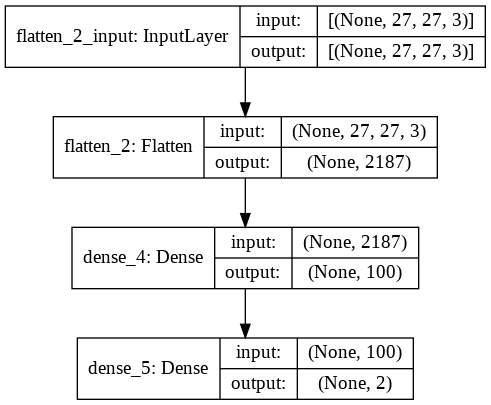

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [40]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [43]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


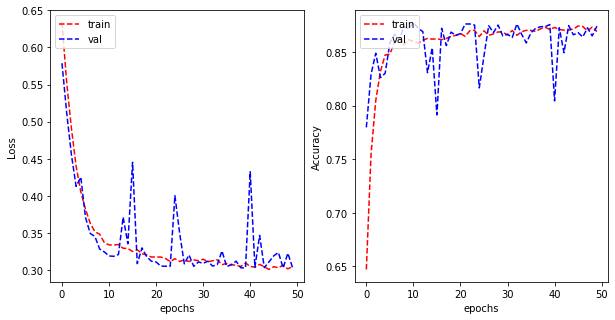

In [45]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

The model can be seen to have overfitting when plotted for both loss and accuracy.

#### **Testing the Baseline Model**
The baseline model is applied to the test dataset and predicts whether images are cancerous or non-cancerous. The model was evaluated to have a loss of 30.76% and an accuracy of 87.63%.

In [48]:
# Attaches images from the test data to their actual 'isCancerous' values
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
model.evaluate(test_generator)

1980/1980 [==============================] - 3s 1ms/step - loss: 0.3076 - categorical_accuracy: 0.8763


[0.3075571358203888, 0.8762626051902771]

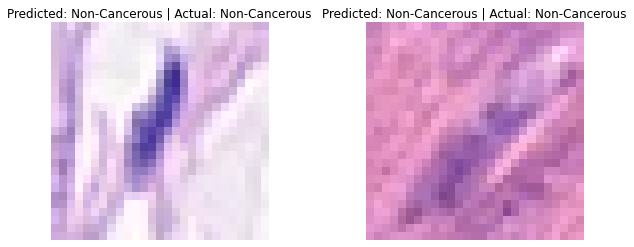

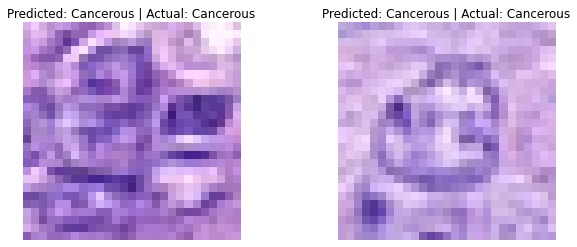

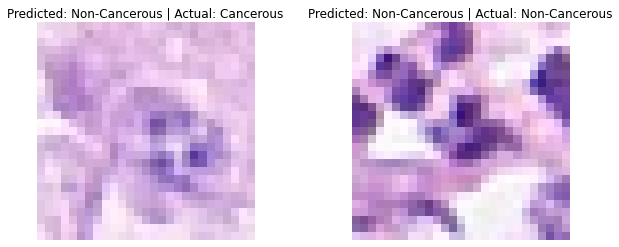

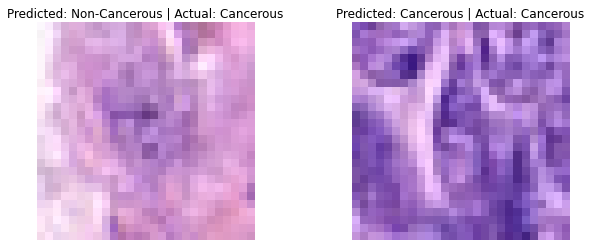

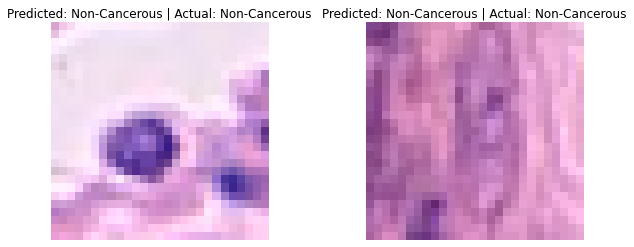

In [63]:
# Examples of the predicted results against the actual data on the test set
label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

z = 0
while z < 5:
  d_inv = {v: k for k, v in label_names.items()}
  plt.figure(figsize=(16,4))
  batches = 0
  for x,y in test_generator:
          batches = batches + 1
          y_hat = model.predict(x, verbose=0)
          x = np.squeeze(x)
          if batches < 3:
              plt.subplot(1,3,batches)
              plt.imshow(x)
              plt.title("Predicted: {} | Actual: {}".format(d_inv[np.argmax(y_hat[0])] , d_inv[np.argmax(y[0])]))
              
          else:
              break
          
          plt.axis('off')

  z = z + 1

# Linear Regression Model